In [19]:
## Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import pickle
import streamlit as st
import cv2
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import pickle
import winsound

In [20]:
## Read in the CSV file
csv_file_path = 'archive/age_gender.csv'
data = pd.read_csv(csv_file_path)

## Convert the 'pixels' column to numpy arrays:
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype=np.float32))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [21]:
# ##Display the first image for testing and learing purposes
height = 48
width = 48

# number = 23700

# chosen_image_pixels = data['pixels'].iloc[number]
# chosen_image_age = data['age'].iloc[number]
# chosen_image_gender = data['gender'].iloc[number]
# chosen_image_ethnicity = data['ethnicity'].iloc[number]

# print("Age:", chosen_image_age)
# print("Gender:", chosen_image_gender)
# print("Ethnicity:", chosen_image_ethnicity)

# first_image_2d = chosen_image_pixels.reshape(height, width)

# plt.imshow(first_image_2d, cmap='gray')
# plt.axis('off')
# plt.show()

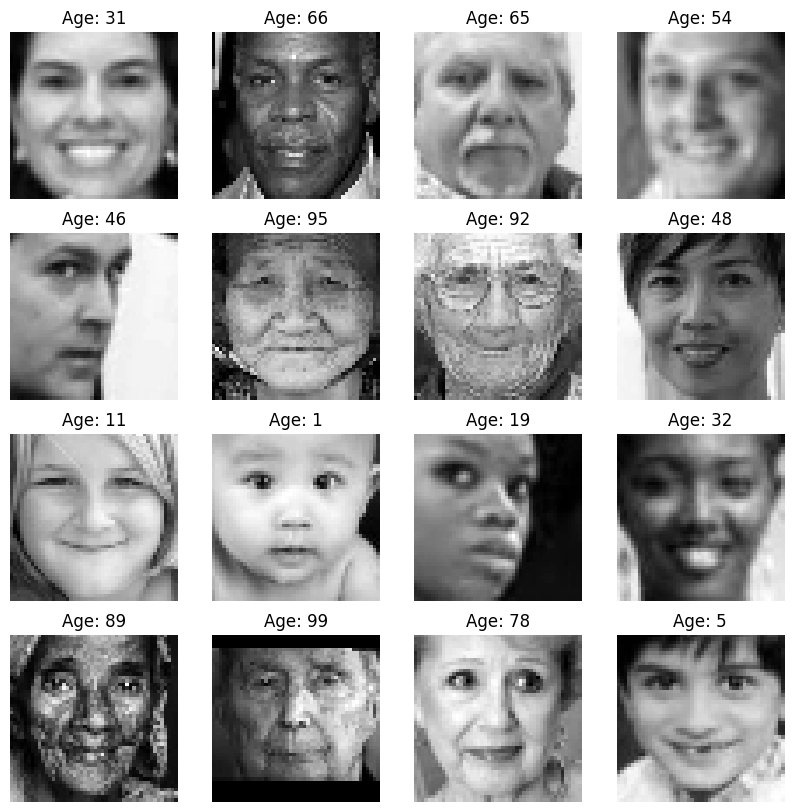

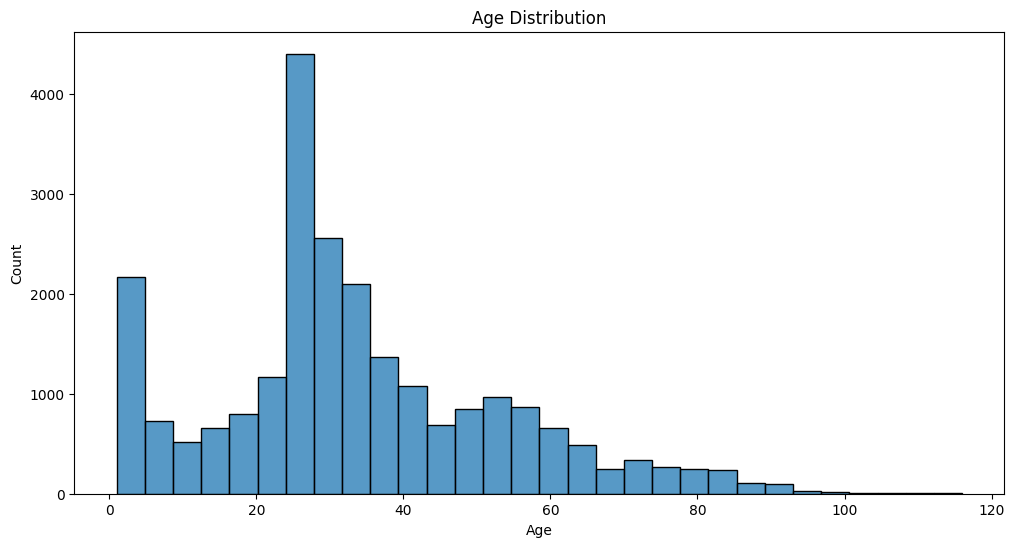

In [22]:
# Number of rows and columns in the grid
grid_rows = 4
grid_cols = 4

# Create a grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 10))

# Group by 'age' and select the first image from each group
grouped = data.groupby('age').first().reset_index()

# Get a sample of age groups
sample = grouped.sample(grid_rows * grid_cols, random_state=42)

for i, (index, row) in enumerate(sample.iterrows()):
    # Convert the flat array into a 2D image
    img = np.array(row['pixels']).reshape(height, width)
    
    # Calculate the corresponding row and column in the grid
    row_index = i // grid_cols
    col_index = i % grid_cols

    # Display the image in the corresponding subplot
    axes[row_index, col_index].imshow(img, cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(f"Age: {row['age']}")

# Show the grid of images
plt.show()

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the age distribution
sns.histplot(data=data, x='age', bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

In [23]:
##Split the data into input features (X) and target labels (y):
X = np.stack(data['pixels'].values)
y = data['age'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
##Reshape the 'pixels' arrays into images and normalize the pixel values:
height, width, channels = 48, 48, 1  # Adjust these values according to your dataset

X_train = X_train.reshape(-1, height, width, channels) / 255.0
X_val = X_val.reshape(-1, height, width, channels) / 255.0

In [25]:
model = models.Sequential([
    layers.InputLayer(input_shape=(height, width, channels)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [26]:
# Set up early stopping with a patience of, say, 20 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<80):
            print("\nReached 80 val_loss so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[callback, early_stopping])

# Save the trained model to a file
model_save_path = 'models/age_regression_model.h5'

if not os.path.exists('models'):
    os.mkdir('models')

model.save(model_save_path)


Epoch 1/20
593/593 [==============================] - 26s 41ms/step - loss: 401.1212 - mae: 15.4306 - val_loss: 267.6891 - val_mae: 12.3001
Epoch 2/20
593/593 [==============================] - 23s 39ms/step - loss: 261.0207 - mae: 12.3643 - val_loss: 191.1136 - val_mae: 10.5646
Epoch 3/20
593/593 [==============================] - 26s 44ms/step - loss: 213.2394 - mae: 11.0540 - val_loss: 166.0985 - val_mae: 9.8834
Epoch 4/20
593/593 [==============================] - 25s 41ms/step - loss: 183.7792 - mae: 10.2392 - val_loss: 189.0230 - val_mae: 10.1384
Epoch 5/20
593/593 [==============================] - 24s 41ms/step - loss: 163.1761 - mae: 9.4677 - val_loss: 191.1834 - val_mae: 10.1101
Epoch 6/20
593/593 [==============================] - 24s 40ms/step - loss: 144.4056 - mae: 8.9055 - val_loss: 168.4131 - val_mae: 9.4246
Epoch 7/20
593/593 [==============================] - 24s 40ms/step - loss: 130.8875 - mae: 8.3970 - val_loss: 180.9891 - val_mae: 10.0576
Epoch 8/20
593/593 [=====

In [27]:
# Evaluate the model on the test dataset
model = load_model('models/age_regression_model.h5')

val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation MSE: {val_loss}")
print(f"Validation MAE: {val_mae}")

OSError: No file or directory found at models/age_regression_model.h5

In [ ]:
##Visualize training history


def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

plot_history(history)

NameError: name 'history' is not defined

In [ ]:
## Testing the modell on my own image

# Load your image
image_path = 'Images/19en.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(image, (48, 48))

# Reshape and normalize the image
input_image = resized_image.reshape(1, 48, 48, 1) / 255.0

predicted_age = model.predict(input_image)

# Display the result
print(f'Predicted age: {predicted_age[0][0]}')

1/1 [==============================] - 0s 110ms/step
Predicted age: 48.49895477294922


In [ ]:
# Load the model
model = load_model('models/age_regression_model.h5')

# Save the model as a pickle object
pickle.dump(model, open('model.sav', 'wb'))